In [1]:
from skbio.stats.ordination import pcoa
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score,  average_precision_score
from q2_anomaly_detection.utils import as_dense
from q2_anomaly_detection.preprocessing import MinMaxScaler
from q2_anomaly_detection.cross_validation import column_value_splitter
from friendly_guacamole.datasets import DietInterventionStudy
%matplotlib inline

In [2]:

RANDOM_SEED = 825
RAREFACTION_DEPTH = 4000

dataset = DietInterventionStudy('data/diet_intervention')

Files already downloaded and verified


In [3]:
table = dataset['table']
print(table.shape)
metadata_all = dataset['metadata']
table_ids = set(table.ids())
metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids')
metadata = metadata.set_index('sample_name')

table.filter(metadata.index, axis='sample')

(7107, 408)


7107 x 328 <class 'biom.table.Table'> with 246418 nonzero entries (10% dense)

In [4]:
np.random.seed(RANDOM_SEED)
subtable = table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]


In [5]:
subtable.shape



(3056, 326)

In [6]:
study_ids = subtable.ids('sample')
dm = pdist(subtable.matrix_data.todense().transpose(), metric='jaccard')
pcoa_results = pcoa(dm)
pcoa_results.samples.index = study_ids
pcoa_with_metadata = pcoa_results.samples.join(metadata)


/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


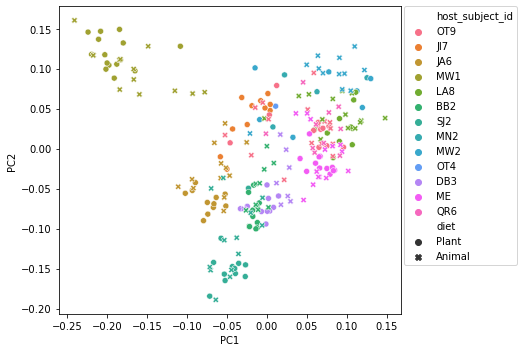

In [7]:
plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue='host_subject_id',
                     style='diet',
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

In [13]:


metadata.columns

Index(['collection_date_publication', 'collection_time',
       'collection_timestamp', 'country', 'day', 'description', 'diet',
       'elevation', 'empo_1', 'empo_2', 'empo_3', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_age',
       'host_age_units', 'host_body_habitat', 'host_body_mass_index',
       'host_body_product', 'host_body_site', 'host_common_name',
       'host_height', 'host_height_units', 'host_scientific_name',
       'host_subject_id', 'host_taxid', 'host_weight', 'host_weight_units',
       'latitude', 'longitude', 'place', 'qiita_study_id', 'sample_type',
       'scientific_name', 'sex', 'subjdiet', 'subjectfood', 'taxon_id',
       'title'],
      dtype='object')

In [15]:
metadata['subjdiet'].value_counts()


Plant-6      15
Animal-8     15
Animal-2     14
Animal-1     14
Animal-4     13
Plant-8      13
Animal-6     13
Plant-4      12
Animal-5     12
Animal-10    12
Plant-2      12
Plant-7      11
Plant-5      11
Plant-10     11
Plant-3      10
Plant-9      10
Animal-9     10
Animal-11    10
Plant-1      10
Animal-3      8
Name: subjdiet, dtype: int64

In [17]:
metadata['diet'].value_counts()


Animal    121
Plant     115
Name: diet, dtype: int64